In [18]:
# Import libraries
import matplotlib.pyplot as plt; import numpy as np; import netCDF4; from netCDF4 import Dataset
import pandas as pd; import numpy.ma as ma; import time as timeit; import os; import math
import itertools; import scipy.io; import mat73; import collections
import cartopy; import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import AutoMinorLocator; from matplotlib.ticker import FixedLocator
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
%matplotlib inline
import statistics; import xarray as xr; import matplotlib as mpl; import gsw

In [3]:
file_in ='Etopo1_Bed_35_65N_40_80W.nc'
NC=Dataset(file_in); DS=xr.open_dataset(file_in)
projection= ccrs.PlateCarree(central_longitude=255);
data_crs = ccrs.PlateCarree()

In [4]:
latNC= NC['lat'][:]
lonNC= NC['lon'][:]
depthNC= NC['depth'][:]

In [14]:
small = pd.read_csv('march.csv')
seasonyeardepth = abs(small['glorys']+small['diff'])
small['obs_MLD'] = seasonyeardepth

In [15]:
print(small.shape)

(2663, 7)


In [13]:
print(np.nanmean(seasonyeardepth))

25.321967705595192


In [16]:
print(np.nanmean(seasonyeardepth))

20.40236664162284


In [10]:
print(np.nanmean(small['glorys']))

44.75762889723573


In [11]:
large = pd.read_csv('03.csv')

In [14]:
print(small[0:5])

   Unnamed: 0      lon      lat       diff  years     glorys  obs_MLD
0           0  69.4317  40.2367  -8.657768   1993  41.657768     33.0
1           1  69.4850  40.8667 -33.674065   1993  39.674065      6.0
2           2  69.4500  40.7183  -9.564441   1993  15.564441      6.0
3           3  69.2550  40.6517  -4.986664   1993  10.986664      6.0
4           4  69.4417  40.5533  -6.359997   1993  12.359997      6.0


In [13]:
print(large[0:5])

   Unnamed: 0  obs_lat  obs_lon  date  year  glorys_index_lat  \
0           0  38.1917  73.8133    68  1993                38   
1           1  38.1517  74.0450    68  1993                38   
2           2  37.9800  74.0467    68  1993                36   
3           3  37.8100  74.3867    69  1993                34   
4           4  37.6883  74.4817    69  1993                32   

   glorys_index_lon  glorys_lat  glorys_lon  
0                50   38.166668  -73.833336  
1                47   38.166668  -74.083336  
2                47   38.000000  -74.083336  
3                43   37.833332  -74.416664  
4                42   37.666668  -74.500000  


In [12]:
print(len(large))

4111


In [10]:
filenow = 'glorys12v1_depth.nc'
BC=Dataset(filenow); BS=xr.open_dataset(filenow)

In [11]:
glorysdepth = np.asarray(BS['depth'].values)

In [12]:
file_in ='03.nc'
NC=Dataset(file_in); DS=xr.open_dataset(file_in)

In [13]:
print(len(DS['T']))

4111


In [43]:
glorysdens_myway = []; indices = []; news = []; newnews = []
for i in range(len(DS['T'])):
    a = np.asarray(DS['T'][i])
    b = np.asarray(DS['S'][i])
    ctemp = []; density = []
    for ii in range(len(a)):
        CT = gsw.CT_from_pt(a[ii],b[ii])
        ctemp.append(CT)
        DENS = gsw.sigma0(b[ii],CT)
        density.append(DENS)
    dffinunreversed = pd.DataFrame({'temp': a,'sal': b, 's': b, 'CT': ctemp, 'density': density, 'depth':glorysdepth})
    surfacevalmean = np.mean(dffinunreversed['density'][0:5])
    news.append(surfacevalmean)
    newnews.append(dffinunreversed)
for v in range(len(newnews)):
    dffinunreversednow = newnews[v]
    for ix in range(len(dffinunreversednow)):
        if dffinunreversednow.at[ix,'density'] >= (news[v] - 0.03) and dffinunreversednow.at[ix,'density'] <= (news[v] + 0.03):
            pass
        else:
            glorysdens_myway.append(dffinunreversednow.at[ix,'depth'])
            indices.append(v)
            break

In [45]:
print(len(newnews))

4111


In [44]:
print(len(indices))

4098


In [25]:
how = list(range(0,4011))

In [26]:
def find_missing(lst): 
    start = lst[0] 
    end = lst[-1] 
    return sorted(set(range(start, end + 1)).difference(lst))

In [47]:
print(find_missing(indices))

[332, 521, 733, 1327, 1341, 1699, 1722, 1998, 2069, 2305, 2462, 2470, 2660]


In [54]:
myglorysmld = pd.DataFrame({'indices': indices,'glorysmld_new':glorysdens_myway})

In [66]:
merged_large = pd.merge(large, myglorysmld, left_on=['Unnamed: 0'], right_on = ['indices'], left_index=False, how='outer', sort=False)


In [56]:
print(len(large))

4111


In [71]:
print(large.shape)
print(merged_large.shape)
print(small.shape)

(4111, 9)
(4111, 11)
(2663, 6)


In [79]:
glorys12v1 ='global-reanalysis-phy-001-030-daily_1596465428590.nc'

In [81]:
DS=xr.open_dataset(glorys12v1)

In [84]:
year = 1993
use=DS.sel(time=slice('{}-03-01'.format(year),'{}-03-31'.format(year)))
locate_date = use.sel(time=use.time.dt.day==(68)-59)
mld_locate_date = locate_date.mlotst.values[0]

In [86]:
print(mld_locate_date[38, 47])

17.24296


In [87]:
print(merged_large.iloc[1])

Unnamed: 0             1.000000
obs_lat               38.151700
obs_lon               74.045000
date                  68.000000
year                1993.000000
glorys_index_lat      38.000000
glorys_index_lon      47.000000
glorys_lat            38.166668
glorys_lon           -74.083336
indices                1.000000
glorysmld_new         65.807266
Name: 1, dtype: float64


In [89]:
hihi = abs(nice_march['diff']+nice_march['glorys'])

In [92]:
hey = nice_march['diff']+nice_march['glorys']

In [105]:
print(np.nanmin(nice_march['diff']))
print(np.nanmax(nice_march['diff']))
print(np.nanmean(nice_march['diff']))

-121.31700134277344
205.19852256774902
-2.324652834907119


In [104]:
print(np.nanmean(hihi))
print(np.nanmax(hihi))
print(np.nanmin(hihi))
print('')
print(np.nanmean(hey))
print(np.nanmax(hey))
print(np.nanmin(hey))

20.364751667902148
220.0
4.70000000000001

20.364751667902148
220.0
4.70000000000001


In [97]:
diff_glorys = nice_march['glorysmld_new'] - nice_march['glorys']

In [102]:
print(np.nanmean(diff_glorys))
print(np.nanmax(diff_glorys))
print(np.nanmin(diff_glorys))

15.962736543679432
233.43854522705078
-37.811092376708984


In [88]:
print(nice_march.iloc[2])

Unnamed: 0_x           1.000000
obs_lat               38.151700
obs_lon               74.045000
date                  68.000000
year                1993.000000
glorys_index_lat      38.000000
glorys_index_lon      47.000000
glorys_lat            38.166668
glorys_lon           -74.083336
indices                1.000000
glorysmld_new         65.807266
Unnamed: 0_y         789.000000
lon                   74.045000
lat                   38.151700
diff                  11.757040
years               1993.000000
glorys                17.242960
Name: 789.0, dtype: float64


In [641]:
# nice = pd.merge(largenew, small, left_on=['obs_lon','obs_lat'], right_on = ['lon','lat'], left_index=True, how='outer', sort=False)

In [74]:
nice_march = pd.merge(merged_large, small, left_on=['obs_lon','obs_lat'], right_on = ['lon','lat'], left_index=True, how='outer', sort=False)


In [660]:
# nice_march = pd.merge(largenew, small, left_on=['obs_lon','obs_lat'], right_on = ['lon','lat'], left_index=True, how='outer', sort=False)


In [75]:
print(nice_march.shape)

(4145, 17)


In [96]:
nice_march.iloc[0:10]

,Unnamed: 0_x,obs_lat,obs_lon,date,year,glorys_index_lat,glorys_index_lon,glorys_lat,glorys_lon,indices,glorysmld_new,Unnamed: 0_y,lon,lat,diff,years,glorys
788.0,0,38.1917,73.8133,68,1993,38,50,38.166668,-73.833336,0.0,21.598820,788.0,73.8133,38.1917,-2.122959,1993.0,13.122959
789.0,1,38.1517,74.0450,68,1993,38,47,38.166668,-74.083336,1.0,65.807266,789.0,74.0450,38.1517,11.757040,1993.0,17.242960
790.0,2,37.9800,74.0467,68,1993,36,47,38.000000,-74.083336,2.0,21.598820,790.0,74.0467,37.9800,0.640003,1993.0,12.359997
791.0,3,37.8100,74.3867,69,1993,34,43,37.833332,-74.416664,3.0,65.807266,791.0,74.3867,37.8100,3.773336,1993.0,19.226664
792.0,4,37.6883,74.4817,69,1993,32,42,37.666668,-74.500000,4.0,55.764290,792.0,74.4817,37.6883,-7.785181,1993.0,16.785181
793.0,5,37.6450,74.4150,69,1993,32,43,37.666668,-74.416664,5.0,40.344051,793.0,74.4150,37.6450,19.367411,1993.0,16.632589
999.0,5,37.6450,74.4150,69,1993,32,43,37.666668,-74.416664,5.0,40.344051,999.0,74.4150,37.6450,5.786673,1996.0,30.213327
793.0,444,37.6450,74.4150,68,1996,32,43,37.666668,-74.416664,444.0,29.444731,793.0,74.4150,37.6450,19.367411,1993.0,16.632589
999.0,444,37.6450,74.4150,68,1996,32,43,37.666668,-74.416664,444.0,29.444731,999.0,74.4150,37.6450,5.786673,1996.0,30.213327
794.0,6,37.4700,74.4517,69,1993,30,43,37.500000,-74.416664,6.0,25.211411,794.0,74.4517,37.4700,17.961485,1993.0,14.038515


In [663]:
print(nice.shape)
# nice # is January
# nice_feb 
# nice_dec

(1157, 16)


In [ ]:
spring = [nice_march, nice_march, nice_dec]



In [664]:
winter = [nice, nice_feb, nice_dec]

winter_df = pd.concat(winter)

In [665]:
print(winter_df)

       Unnamed: 0_x  obs_lat  obs_lon  date  year  glorys_index_lat  \
633.0             0  40.9517  71.1700     6  1993                71   
634.0             1  40.6983  71.0500     6  1993                68   
635.0             2  40.6517  70.5500     6  1993                68   
636.0             3  40.8317  70.3833     6  1993                70   
637.0             4  40.9017  70.6833     6  1993                71   
...             ...      ...      ...   ...   ...               ...   
NaN             253  41.0383  70.2283   342  2011                72   
NaN             254  41.0367  70.2817   342  2011                72   
NaN             255  41.0367  70.3333   342  2011                72   
NaN             256  41.0367  70.3983   342  2011                72   
NaN             257  41.0600  70.5133   342  2011                73   

       glorys_index_lon  glorys_lat  glorys_lon  glorysmyway  Unnamed: 0_y  \
633.0                82   40.916668  -71.166664    55.764290         

In [643]:
# nice.loc[nice.index.isnull()]

In [516]:
print(len(DS['T']))
print(len(large))

1143
1143


In [541]:
print(DS['T'][1080])
print(DS['S'][1080])
a = DS['T'][1080]
b = DS['S'][1080]
ctemp = []
density = []
for ii in range(len(a)):
    CT = gsw.CT_from_pt(a[ii],b[ii])
    ctemp.append(CT)
    DENS = gsw.sigma0(b[ii],CT)
    density.append(DENS)
print(density)

<xarray.DataArray 'T' (depth: 32)>
array([1.168258e+01, 1.168258e+01, 1.168258e+01, 1.168258e+01, 1.168258e+01,
       1.168258e+01, 1.168258e+01, 1.168258e+01, 1.168331e+01, 1.168477e+01,
       1.169283e+01, 1.171627e+01, 1.179098e+01, 1.197922e+01, 1.225755e+01,
       1.258422e+01, 1.287280e+01, 1.304566e+01, 1.313868e+01, 1.318702e+01,
       1.321265e+01, 1.328809e+01, 1.343605e+01, 1.346974e+01, 1.368215e+01,
       1.361916e+01, 9.969210e+36, 9.969210e+36, 9.969210e+36, 9.969210e+36,
       9.969210e+36, 9.969210e+36])
Dimensions without coordinates: depth
<xarray.DataArray 'S' (depth: 32)>
array([3.513749e+01, 3.513749e+01, 3.513749e+01, 3.513749e+01, 3.513749e+01,
       3.513749e+01, 3.513749e+01, 3.513749e+01, 3.513749e+01, 3.513749e+01,
       3.513901e+01, 3.514512e+01, 3.516343e+01, 3.521378e+01, 3.529008e+01,
       3.538316e+01, 3.546861e+01, 3.552202e+01, 3.555101e+01, 3.556780e+01,
       3.557390e+01, 3.559526e+01, 3.564257e+01, 3.565935e+01, 3.570513e+01,
       3.

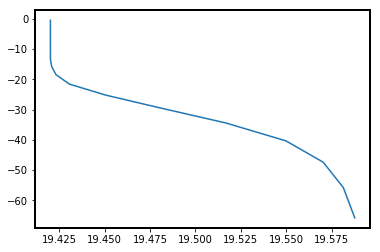

In [542]:
plt.plot(density[0:20],glorysdepth[0:20]*-1)

In [ ]:
plt.plot(density[0:20],glorysdepth[0:20]*-1)

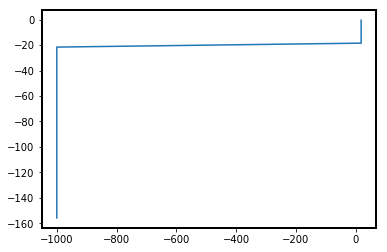

In [724]:
plt.plot(density[0:25],glorysdepth[0:25]*-1)

In [722]:
print(glorysdepth)

[4.940250e-01 1.541375e+00 2.645669e+00 3.819495e+00 5.078224e+00
 6.440614e+00 7.929560e+00 9.572997e+00 1.140500e+01 1.346714e+01
 1.581007e+01 1.849556e+01 2.159882e+01 2.521141e+01 2.944473e+01
 3.443415e+01 4.034405e+01 4.737369e+01 5.576429e+01 6.580727e+01
 7.785385e+01 9.232607e+01 1.097293e+02 1.306660e+02 1.558507e+02
 1.861256e+02 2.224752e+02 2.660403e+02 3.181274e+02 3.802130e+02
 4.539377e+02 5.410889e+02]


In [506]:
print(nice.iloc[1088])

Unnamed: 0_x        1080.000000
obs_lat               38.770000
obs_lon               73.046700
date                  31.000000
year                2009.000000
glorys_index_lat      45.000000
glorys_index_lon      59.000000
glorys_lat            38.750000
glorys_lon           -73.083336
glorysmyway           25.211411
Unnamed: 0_y         864.000000
lon                   73.046700
lat                   38.770000
diff                  36.749657
years               2009.000000
glorys                91.250343
Name: 864.0, dtype: float64


In [ ]:
glorys                91.250343
glorysmyway           25.211411

In [462]:
newdiff = nice['glorysmyway'] - nice['glorys']

In [721]:
print(np.min(newdiff))
print(np.argmin(newdiff))
print(np.max(newdiff))
print(np.argmax(newdiff))

11.935858726501465
0
11.935858726501465
0


In [545]:
print(np.mean(newdiff))

11.595873508618508


In [546]:
seasonyeardepth = nice['glorys'] + nice['diff']

In [553]:
seasonyeardepthdiffwithmyway = seasonyeardepth - nice['glorysmyway']

In [562]:
nice['glorys'][6]

11.597034454345705

In [ ]:
diff = obs - glorys
diff + glorys

In [687]:
indexlist = []; newdifflist = []; seasonyeardepthlist = []; gloryslist = []; glorysmywaylist = []; difflist = []
newdf = pd.DataFrame({'lon': winter_df['lon'],'lat': winter_df['lat']})
for ii in range(len(newdf)):
    new = newdf.iloc[ii].values
    point = Point(new)
    if polygon_t.contains(point) == True:
        indexlist.append(ii)
        newdiff = winter_df['glorysmyway'].iloc[ii] - winter_df['glorys'].iloc[ii]
        newdifflist.append(newdiff)
        seasonyeardepth = winter_df['glorys'].iloc[ii] + np.abs(winter_df['diff'].iloc[ii])
        seasonyeardepthlist.append(seasonyeardepth)
        gloryslist.append(winter_df['glorys'].iloc[ii])
        glorysmywaylist.append(winter_df['glorysmyway'].iloc[ii])
        difflist.append(winter_df['diff'].iloc[ii])

In [741]:
print(len(indices))

8209


In [688]:
print(seasonyeardepthlist)

[30.64147186279297, 30.322952270507812, 49.0, 60.0, 38.0, 67.24443054199219, 74.1584930419922, 75.0, 75.0, 107.0, 70.00885009765624, 106.91849517822266, 33.050357818603516, 23.0, 85.8607177734375, 90.9896011352539, 63.0, 50.7955322265625, 89.0873794555664, 79.44441986083984, 72.0, 107.5807113647461, 61.0, 75.3332977294922, 79.0, 130.72291564941406, 112.0, 150.46217346191406, 50.718505859375, 109.0, 118.0, 64.0, 53.20591354370117, 61.46367645263672, 93.0, 108.99999999999999, 77.0, 123.0, 60.411827087402344, 101.0, 135.0, 106.0, 163.98809814453125, 105.69775390625, 121.0, 159.71551513671875, 105.69775390625, 106.112548828125, 98.0, 106.112548828125, 98.0, 177.41624450683594, 93.0, 94.0, 96.0, 101.0, 106.0, 105.0, 84.0, 89.0, 73.0, 99.0, 68.0, 90.0, 167.95550537109375, 84.0, 82.0, 65.0, 79.00000000000001, 107.0, 24.21332550048828, 27.0, 42.0, 83.81478881835938, 77.5481185913086, 84.86663818359375, 110.0, 134.0, 75.0, 150.25477600097656, 63.00000000000001, 67.0, 45.0, 71.00000000000001, 93

In [683]:
print(winter_df['diff'])

633.0   -30.469620
634.0    19.397043
635.0    -2.151100
636.0    -8.251842
637.0    -9.106663
           ...    
NaN            NaN
NaN            NaN
NaN            NaN
NaN            NaN
NaN            NaN
Name: diff, Length: 4839, dtype: float64


In [684]:
print(winter_df['glorys'])

633.0    36.469620
634.0    29.602957
635.0    47.151100
636.0    44.251842
637.0    15.106663
           ...    
NaN            NaN
NaN            NaN
NaN            NaN
NaN            NaN
NaN            NaN
Name: glorys, Length: 4839, dtype: float64


In [682]:
print(np.mean(seasonyeardepth))

14.551103591918945


In [677]:
print(np.mean(gloryslist))
print(np.mean(glorysmywaylist))
print('')
print(np.std(gloryslist))
print(np.std(glorysmywaylist))

54.003246035170456
74.59550623951654

27.79628852065598
28.91523162143223


# print(indexlist)

In [609]:
print(seasonyeardepthlist)

[6.0000000000000036, 49.0, 45.0, 36.0, 6.0, 6.000000000000002, 19.999999999999996, 6.0, 15.0, 55.0, 13.999999999999996, 35.0, 29.0, 6.0, 50.0, 43.0, 6.0, 6.0000000000000036, 24.999999999999993, 72.0, 61.0, 32.0, 58.0, 24.999999999999996, 31.0, 17.0, 6.0, 43.0, 15.999999999999998, 15.0, 6.0, 6.0, 6.0, 6.0, 6.0, 20.0, 6.000000000000002, 6.0, 6.0, 6.0, 62.0, 53.0, 32.0, 38.0, 56.0, 81.0, 47.0, 6.0, 47.00000000000001, 55.0, 5.999999999999986, 6.0, 16.000000000000004, 65.0, 6.0, 6.0, 6.0, 6.0, 5.999999999999998, 6.0000000000000036, 6.0, 6.0, 6.0, 6.0, 17.0, 57.0, 11.0, 28.0, 53.0, 42.0, 45.0, 6.000000000000007, 6.0000000000000036, 6.0000000000000036, 6.0, 6.0, 54.0, 54.0, 71.0, 30.0, 45.00000000000001, 58.0, 56.0, 68.0, 6.0, 6.0, 6.0000000000000036, 6.0, 6.0, 6.0, 59.0, 6.0, 59.00000000000001, 41.0, 40.0, 24.0, 26.0, 6.0, 6.0, 6.0, 28.0, 6.0, 6.0, 6.000000000000007, 6.0, 6.0, 6.0, 24.0, 26.0, 16.0, 30.0, 77.0, 23.0, 46.0, 76.0, 8.0, 22.0, 36.0, 15.0, 13.0, 50.0, 46.0, 22.0, 25.0, 28.0, 33.0

In [610]:
print(gloryslist)

[36.46961975097656, 29.602956771850586, 47.151100158691406, 44.2518424987793, 15.10666275024414, 12.817774772644045, 28.992586135864254, 46.54072952270508, 37.69036102294922, 40.2844352722168, 40.2844352722168, 40.43702697753906, 44.709617614746094, 40.58961868286133, 40.13184356689453, 36.16443634033203, 37.07999038696289, 36.622215270996094, 66.68294525146484, 77.51701354980469, 76.44886779785156, 59.5110969543457, 72.48146057128906, 45.167396545410156, 48.677024841308594, 18.311107635498047, 49.43998718261719, 39.67406463623047, 13.580737113952635, 15.10666275024414, 26.551105499267575, 50.81332015991211, 58.90072631835938, 48.82961654663086, 29.45036315917969, 16.022218704223633, 16.937774658203125, 22.583698272705078, 46.693321228027344, 60.5792465209961, 69.12442779541016, 52.79702377319336, 50.96591567993164, 43.4888801574707, 45.31998825073242, 62.71554183959961, 66.83553314208984, 52.18665313720703, 60.5792465209961, 57.52739334106445, 72.6340560913086, 65.76738739013672, 47.4

In [611]:
print(glorysmywaylist)

[55.76428985595703, 40.344051361083984, 55.76428985595703, 55.76428985595703, 29.444730758666992, 15.810070037841797, 40.344051361083984, 55.76428985595703, 47.37369155883789, 47.37369155883789, 47.37369155883789, 47.37369155883789, 55.76428985595703, 55.76428985595703, 47.37369155883789, 47.37369155883789, 40.344051361083984, 40.344051361083984, 77.85385131835938, 77.85385131835938, 77.85385131835938, 65.80726623535156, 77.85385131835938, 47.37369155883789, 55.76428985595703, 25.211410522460938, 55.76428985595703, 47.37369155883789, 18.495559692382812, 21.598819732666016, 34.43415069580078, 55.76428985595703, 65.80726623535156, 55.76428985595703, 34.43415069580078, 21.598819732666016, 21.598819732666016, 29.444730758666992, 47.37369155883789, 65.80726623535156, 77.85385131835938, 55.76428985595703, 55.76428985595703, 47.37369155883789, 47.37369155883789, 65.80726623535156, 77.85385131835938, 55.76428985595703, 65.80726623535156, 65.80726623535156, 77.85385131835938, 77.85385131835938,

In [586]:
print(np.mean(newdifflist))
print(np.mean(seasonyeardepthlist))
print(np.mean(gloryslist))
print(np.mean(glorysmywaylist))
print(np.mean(difflist))


5.489660383818985
33.01948051948052
36.51123704538717
42.000897429206155
-3.4917565259066494


In [ ]:
6.054530554551345
26.361538461538462
41.68359120442317
47.738121758974515
-15.32205274288471

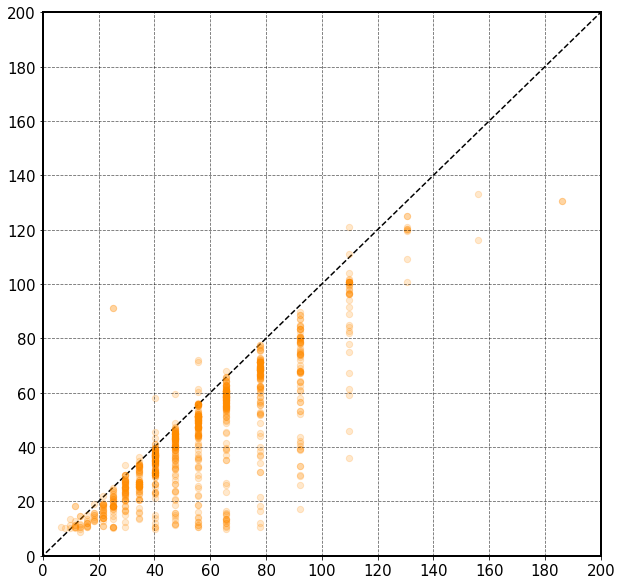

In [720]:
plt.figure(figsize=(10,10))
plt.xlim((0,200))
plt.ylim((0,200))

xlist = [-50,300]
ylist = [-50,300]

# new_ylist_add = [x+7.296282117188131 for x in ylist]
# new_ylist_upper= [x+22.126405703353008 for x in new_ylist_add]
# new_ylist_lower = [x-22.126405703353008 for x in new_ylist_add]

# plt.scatter(res_list_w_glorys, res_list_w_dens, color='blue', s = 20, alpha = 0.1)
# plt.scatter(res_list_w_glorys_su, res_list_w_dens_su, color='green', s = 20, alpha = 0.1)
# plt.scatter(res_list_w_glorys_sp, res_list_w_dens_sp, color='red', s = 20, alpha = 0.1)
plt.scatter(nice['glorysmyway'], nice['glorys'], color='darkorange', s = 40, alpha = 0.2)
# plt.scatter(nice['glorysmyway'], seasonyeardepth, color='blue', s = 20, alpha = 0.1)
# plt.scatter(nice['glorysmyway'], nice['diff'], color='red', s = 20, alpha = 0.1)



plt.plot(xlist,ylist, linestyle='--', color='black', linewidth=1.5, zorder= 0)
# plt.plot(xlist,new_ylist_add, linestyle='-', color='darkblue', linewidth=1.5, zorder= 0)
# plt.plot(xlist,new_ylist_upper, linestyle='-', color='cornflowerblue', linewidth=1.5, zorder= 0)
# plt.plot(xlist,new_ylist_lower, linestyle='-', color='cornflowerblue', linewidth=1.5, zorder= 0)

plt.grid(b=True, which='both', color='black', linestyle='--',alpha = 0.6)
# plt.xlabel('GLORYS-based MLDs', fontsize = 15)
# plt.ylabel('Density-based MLDs', fontsize = 15)
plt.xticks([0,20,40,60,80,100,120,140,160,180,200], fontsize = 15) 
plt.yticks([0,20,40,60,80,100,120,140,160,180,200], fontsize = 15) 
mpl.rcParams['axes.linewidth'] = 2
# plt.text(15, 175, 'SMAB', dict(size=22))

plt.show()

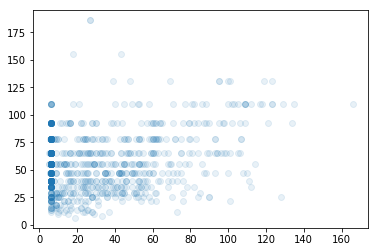

In [470]:
plt.scatter(seasonyeardepth, nice['glorysmyway'],alpha=0.1)

In [ ]:
diff = []; latfull = []; lonfull = []; years = []; glorysfull = []
option1 = []; option2 = []; option3 = []; option4 = []; option5 = []; option6 =[]
pointstouse = []; seasonalmean = []; seasonalstd = []; yearwithdata = []
finallatestdepth = []; finalfinaldepth = []; finalfinalratio = []; filteredMLDlist = []
meanfilteredMLDlist = []; stdfilteredMLDlist = []; years = []; bananasplitmean = []
bananasplitstd = [];floormean = [];floorstd = []; latfinal = []; lonfinal = []; ratiofinal = []
bottomdfinal = []; filteredfloorslist = [];zi_listofarrays = []

for year in range(1993,2019):
    filename = 'casts_{}.mat'.format(year)
    file = scipy.io.loadmat(filename,squeeze_me=True)
    npfile = file['casts_{}'.format(year)]
    
    lat_intermediate = []; lon_intermediate = []; yd_intermediate = []
    p_intermediate = []; t_intermediate = []; sal_intermediate = []
    finaldepth = []; finallat = [];finallon = []
    seasonyeardepth = []; seasonyeartemp = [];seasonyearsal = []; seasonyeardens = []
    counterii = []; floors = []; floor_intermediate = []; s_intermediate = []
    seasonyearsal = []; lat = []; lon = []; lonneg = []; pointstousesmall = []
    yearstodate = []
    for i in range(len(npfile)):
        yd = npfile[i]['yd']
        gear = npfile[i]['gear']
        floordepth = npfile[i]['depth']
        if gear == 'Bottle':
            pass
        if yd > 31 and yd <= 59 and floordepth <= 200: # and floordepth <= 200
            lat_intermediate.append(npfile[i]['lat'])
            lon_intermediate.append(npfile[i]['lon'])
            p_intermediate.append(npfile[i]['p'])
            t_intermediate.append(npfile[i]['t'])
            yd_intermediate.append(npfile[i]['yd'])
            sal_intermediate.append(npfile[i]['s'])
            floor_intermediate.append(npfile[i]['depth'])
    month_df = pd.DataFrame({'day': yd_intermediate,'lon': lon_intermediate,'lat': lat_intermediate, 'p': p_intermediate, 't': t_intermediate,'depth': floor_intermediate, 's': sal_intermediate})
    newdf = pd.DataFrame({'lon': lon_intermediate,'lat': lat_intermediate,'date': yd_intermediate})
    print(year)

    for ii in range(len(month_df)):
        new = newdf.iloc[ii].values
        point = Point(new)
        if isinstance(month_df['p'].iloc[ii], int) or isinstance(month_df['p'].iloc[ii], float) or isinstance(month_df['t'].iloc[ii], int) or isinstance(month_df['t'].iloc[ii], float):
            pass
#         elif polygon_w.contains(point) == True or polygon_y.contains(point) == True or polygon_t.contains(point) == True:
        elif polygon_x.contains(point) == True or polygon_v.contains(point) == True:
            CT = gsw.CT_from_pt(month_df['s'].iloc[ii],month_df['t'].iloc[ii])
            DENS = gsw.sigma0(month_df['s'].iloc[ii],CT)
            pt_df = pd.DataFrame({'p': month_df['p'].iloc[ii],'t': month_df['t'].iloc[ii], 's': month_df['s'].iloc[ii], 'CT': CT, 'DENSMLD': DENS}) 
            df_ptsnew = pt_df.dropna()
            df_final = pd.DataFrame(df_ptsnew.values)
            l=[i for i in df_final[0] if i<=6] 
            if len(l) > 0:
                surfaceval = []; numrange = []
                for iii in range(len(l)):
                    val = df_final[1][iii]
                    numrange.append(iii)
                    surfaceval.append(val)            
            surfacevalmean = statistics.mean(surfaceval)
            densfin = []; tempfin = []; pressurefin = []; salfin = []
            for iii in range(numrange[-1],len(df_final)):
                tempfin.append(df_final[1][iii])
                pressurefin.append(df_final[0][iii])
                salfin.append(df_final[2][iii])
                densfin.append(df_final[4][iii])
            d = {'temp': list(reversed(tempfin)), 'sal': list(reversed(salfin)), 'pressure': list(reversed(pressurefin)),'density': list(reversed(densfin))}
            dunreversed = {'temp': list(tempfin), 'sal': list(salfin), 'pressure': list(pressurefin), 'density': list(densfin)}
            dffinunreversed = pd.DataFrame(dunreversed)
            dffin = pd.DataFrame(d)
            
            for ix in range(len(dffinunreversed)):
                if dffinunreversed.at[ix,'temp'] >= (surfacevalmean - 0.2) and dffinunreversed.at[ix,'temp'] <= (surfacevalmean + 0.2):
                    if dffinunreversed.at[len(dffinunreversed)-1,'temp'] <= (surfacevalmean + 0.2) and dffinunreversed.at[len(dffinunreversed)-1,'temp'] >= (surfacevalmean - 0.2):
                        looknow = list(dffinunreversed['temp'].values)
                        looknow2 = [i for i in looknow if i >= (surfacevalmean + 0.2)]
                        looknow3 = [i for i in looknow if i <= (surfacevalmean - 0.2)]
                        for now in range(len(looknow)):
                            if looknow[now] >= (surfacevalmean + 0.2):
                                seasonyeardepth.append(list(dffinunreversed['pressure'].values)[now])
                                seasonyeartemp.append(list(dffinunreversed['temp'].values)[now])
                                seasonyearsal.append(list(dffinunreversed['sal'].values)[now])
                                seasonyeardens.append(list(dffinunreversed['density'].values)[now])
                                floors.append(month_df['depth'].iloc[ii])
                                lat.append(month_df['lat'].iloc[ii])
                                lon.append(month_df['lon'].iloc[ii])
                                lonneg.append(month_df['lon'].iloc[ii]*-1)
                                counterii.append(ii)
                                option1.append(ii) # well-defined MLD
                                break
                        if len(looknow2) == 0 and len(looknow3) == 0:
                            seasonyeardepth.append(dffinunreversed.at[len(dffinunreversed)-1,'pressure'])
                            seasonyeartemp.append(dffinunreversed.at[len(dffinunreversed)-1,'temp'])
                            seasonyearsal.append(dffinunreversed.at[len(dffinunreversed)-1,'sal'])
                            seasonyeardens.append(dffinunreversed.at[len(dffinunreversed)-1,'density'])
                            floors.append(month_df['depth'].iloc[ii])
                            lat.append(month_df['lat'].iloc[ii])
                            lon.append(month_df['lon'].iloc[ii])
                            lonneg.append(month_df['lon'].iloc[ii]*-1)
                            counterii.append(ii)
                            option2.append(ii) # fully mixed profile (from some troublesome profiles)
                        break
                    else:
                        pass                    
                else:
                    if dffinunreversed.at[ix,'pressure'] >= (month_df['depth'].iloc[ii] - 6): # ALL MIXED
                        if dffinunreversed.at[ix,'pressure'] == dffinunreversed.at[len(dffinunreversed)-1,'pressure']:
                            if dffinunreversed.at[ix,'pressure'] <= (month_df['depth'].iloc[ii] - 6):
                                pass
                            else:
                                if month_df['depth'].iloc[ii] <= 300:
                                    seasonyeardepth.append(dffinunreversed.at[ix,'pressure'])
                                    seasonyeartemp.append(dffinunreversed.at[ix,'temp'])
                                    seasonyearsal.append(dffinunreversed.at[ix,'sal'])
                                    seasonyeardens.append(dffinunreversed.at[len(dffinunreversed)-1,'density'])
                                    floors.append(month_df['depth'].iloc[ii])
                                    lat.append(month_df['lat'].iloc[ii])
                                    lon.append(month_df['lon'].iloc[ii])
                                    lonneg.append(month_df['lon'].iloc[ii]*-1)
                                    counterii.append(ii)
                                    option3.append(ii)
                        else:
                            if month_df['depth'].iloc[ii] <= 300:
                                seasonyeardepth.append(dffinunreversed.at[ix,'pressure'])
                                seasonyeartemp.append(dffinunreversed.at[ix,'temp'])
                                seasonyearsal.append(dffinunreversed.at[ix,'sal'])
                                seasonyeardens.append(dffinunreversed.at[len(dffinunreversed)-1,'density'])
                                floors.append(month_df['depth'].iloc[ii])
                                lat.append(month_df['lat'].iloc[ii])
                                lon.append(month_df['lon'].iloc[ii])
                                lonneg.append(month_df['lon'].iloc[ii]*-1)
                                counterii.append(ii)
                                option4.append(ii)
                    elif dffinunreversed.at[ix,'pressure'] == 0:
                        pass
                    elif ix == 0: 
                        if month_df['depth'].iloc[ii] <= 300:
                            seasonyeardepth.append(dffinunreversed.at[ix,'pressure'])
                            seasonyeartemp.append(dffinunreversed.at[ix,'temp'])
                            seasonyearsal.append(dffinunreversed.at[ix,'sal'])
                            seasonyeardens.append(dffinunreversed.at[len(dffinunreversed)-1,'density'])
                            floors.append(month_df['depth'].iloc[ii])
                            lat.append(month_df['lat'].iloc[ii])
                            lon.append(month_df['lon'].iloc[ii])
                            lonneg.append(month_df['lon'].iloc[ii]*-1)
                            counterii.append(ii)
                            option5.append(ii)
                    else: # Well-defined mixed layer detected
                        if month_df['depth'].iloc[ii] <= 300:
                            seasonyeardepth.append(dffinunreversed.at[ix,'pressure'])
                            seasonyeartemp.append(dffinunreversed.at[ix,'temp'])
                            seasonyearsal.append(dffinunreversed.at[ix,'sal'])
                            seasonyeardens.append(dffinunreversed.at[len(dffinunreversed)-1,'density'])
                            floors.append(month_df['depth'].iloc[ii])
                            lat.append(month_df['lat'].iloc[ii])
                            lon.append(month_df['lon'].iloc[ii])
                            lonneg.append(month_df['lon'].iloc[ii]*-1)
                            counterii.append(ii)
                            option6.append(ii)
                            break
                    break

    inlat = []; inlon = []; date = []
    for timer in counterii:
        inlat.append(newdf['lat'][timer])
        inlon.append(newdf['lon'][timer])
        date.append(newdf['date'][timer])                 
    if len(seasonyeardepth) > 0:    
#         if len(seasonyeardepth) == 1:  
#             std = 0
#             seasonalstd.append(std)
#         else:
#             seasonalstd.append(statistics.stdev(seasonyeardepth))
        yearwithdata.append(year)
        seasonalmean.append(statistics.mean(seasonyeardepth))
#         seasonalstd.append(statistics.stdev(seasonyeardepth))
        full = pd.DataFrame({'mld': seasonyeardepth,'lat': lat, 'lon': lon, 'date': date}) 
        finallatestdepth.append(seasonyeardepth)
    print(len(seasonyeardepth))
    for x in range(len(date)):
        use=DS.sel(time=slice('{}-02-01'.format(year),'{}-02-28'.format(year))) 
        locate_date = use.sel(time=use.time.dt.day==(date[x])-31)
        mld_locate_date = locate_date.mlotst.values[0]
    
        lat = np.array(locate_date.mlotst['latitude'][:])
        long = np.array(locate_date.mlotst['longitude'][:])
    
        lonneg = [float(i)*-1 for i in inlon]
        distanceslat = []; distanceslon = []
        for i in range(133):
            distanceslat.append((inlat[x] - lat[i])**2)
            index_min_lat = min(range(len(distanceslat)), key=distanceslat.__getitem__)
        for ii in range(181):
            distanceslon.append((lonneg[x] - long[ii])**2)
            index_min_lon = min(range(len(distanceslon)), key=distanceslon.__getitem__)
        lat_index_use, lon_index_use = index_min_lat, index_min_lon
        pointstouse.append(mld_locate_date[lat_index_use, lon_index_use]) 
        yearstodate.append(year)
        pointstousesmall.append(mld_locate_date[lat_index_use, lon_index_use])
#         print('******', pointstousesmall)
    newfull = pd.DataFrame({'mld': seasonyeardepth,'lat': inlat, 'lon': inlon, 'date': date, 'glorys': pointstousesmall}) 
    val1_minus_val10 = list(newfull["mld"] - newfull["glorys"])
    
#     print(val1_minus_val10)
# #     print(newfull)
#     diff.append(val1_minus_val10)
#     print('!!!!!', diff)
#     latfull.append(list(newfull['lat']))
#     lonfull.append(list(newfull['lon']))
#     glorysfull.append(list(newfull['glorys']))
#     years.append(list(yearstodate))

In [115]:
neww = [['', '', '40.00', '', '', '69.50'], ['', '', '40.30', '', '', '68.00'], ['', '', '40.40', '', '', '67.50'], ['', '', '40.60', '', '', '67.00'], ['', '', '40.80', '', '', '66.50'], ['', '', '41.45', '', '', '66.00'], ['', '', '41.80', '', '', '65.70'], ['', '', '42.10', '', '', '66.00'], ['', '', '42.10', '', '', '67.00'], ['', '', '42.10', '', '', '67.50'], ['', '', '41.80', '', '', '68.00'], ['', '', '41.10', '', '', '69.00'], ['', '', '41.00', '', '', '69.50'], ['', '', '40.00', '', '', '69.50']]
lon_w = []; lat_w = []
for i in range(14): 
    w1 = neww[i][2]
    lat_w.append(w1)
    w3 = neww[i][5]
    lon_w.append(w3)
lonlist_w = [float(i) for i in lon_w]; latlist_w = [float(i) for i in lat_w]
lonlist_wneg = [float(i)*-1 for i in lon_w]
df_w = pd.DataFrame({'lon': lonlist_w, 'lat': latlist_w,})
df_w_plottable = pd.DataFrame({'lon': lonlist_wneg, 'lat': latlist_w,})

lonlist_w_plot = [float(i)*-1 for i in lon_w]; latlist_w = [float(i) for i in lat_w]
df_w_plot = pd.DataFrame({'lon': lonlist_w_plot, 'lat': latlist_w,})
x_w = df_w_plot['lon']; y_w = df_w_plot['lat']
polygon_w = Polygon(df_w.values)

In [116]:
newv = [['', '', '37.00', '', '', '76.00'], ['', '', '36.00', '', '', '75.50'], ['', '', '35.50', '', '', '75.00'], ['', '', '36.00', '', '', '74.75'], ['', '', '37.40', '', '', '74.50'], ['', '', '39.50', '', '', '72.00'], ['', '', '40.50', '', '', '74.00'], ['', '', '39.40', '', '', '74.25'], ['', '', '37.00', '', '', '76.00']]
lon_v = []; lat_v = []
for i in range(9): 
    v1 = newv[i][2]
    lat_v.append(v1)
    v3 = newv[i][5]
    lon_v.append(v3)
lonlist_v = [float(i) for i in lon_v]; latlist_v = [float(i) for i in lat_v]
df_v = pd.DataFrame({'lon': lonlist_v, 'lat': latlist_v,})
lonlist_v_plot = [float(i)*-1 for i in lon_v]; latlist_v = [float(i) for i in lat_v]
df_v_plot = pd.DataFrame({'lon': lonlist_v_plot, 'lat': latlist_v,})
x_v = df_v_plot['lon']; y_v = df_v_plot['lat']

lonlist_vneg = [float(i)*-1 for i in lon_v]
df_v_plottable = pd.DataFrame({'lon': lonlist_vneg, 'lat': latlist_v,})
polygon_v = Polygon(df_v.values.tolist())

In [117]:
newx = [['', '', '40.50', '', '', '74.00'], ['', '', '39.50', '', '', '72.00'], ['', '', '40.00', '', '', '71.40'], ['', '', '40.00', '', '', '69.50'], ['', '', '41.00', '', '', '69.50'], ['', '', '41.10', '', '', '70.00'], ['', '', '41.00', '', '', '72.00'], ['', '', '40.50', '', '', '74.00']]
lon_x = []; lat_x = []
for i in range(8): 
    x1 = newx[i][2]
    lat_x.append(x1)
    x3 = newx[i][5]
    lon_x.append(x3)
lonlist_x = [float(i) for i in lon_x]; latlist_x = [float(i) for i in lat_x]
df_x = pd.DataFrame({'lon': lonlist_x, 'lat': latlist_x,})
lonlist_x_plot = [float(i)*-1 for i in lon_x]; latlist_x = [float(i) for i in lat_x]
df_x_plot = pd.DataFrame({'lon': lonlist_x_plot, 'lat': latlist_x,})
x_x = df_x_plot['lon']; y_x = df_x_plot['lat']

lonlist_xneg = [float(i)*-1 for i in lon_x]
df_x_plottable = pd.DataFrame({'lon': lonlist_xneg, 'lat': latlist_x,})
polygon_x = Polygon(df_x.values.tolist())

In [118]:
newy = [['', '', '41.80', '', '', '68.00'], ['', '', '42.10', '', '', '67.50'], ['', '', '42.10', '', '', '67.00'], ['', '', '42.10', '', '', '66.00'], ['', '', '43.00', '', '', '66.00'], ['', '', '44.20', '', '', '66.50'], ['', '', '44.20', '', '', '67.00'], ['', '', '44.20', '', '', '68.00'], ['', '', '41.80', '', '', '68.00']]
lon_y = []; lat_y = []
for i in range(9): 
    y1 = newy[i][2]
    lat_y.append(y1)
    y3 = newy[i][5]
    lon_y.append(y3)
lonlist_y = [float(i) for i in lon_y]; latlist_y = [float(i) for i in lat_y]
df_y = pd.DataFrame({'lon': lonlist_y, 'lat': latlist_y,})
lonlist_y_plot = [float(i)*-1 for i in lon_y]; latlist_y = [float(i) for i in lat_y]
df_y_plot = pd.DataFrame({'lon': lonlist_y_plot, 'lat': latlist_y,})
x_y = df_y_plot['lon']; y_y = df_y_plot['lat']

lonlist_yneg = [float(i)*-1 for i in lon_y]
df_y_plottable = pd.DataFrame({'lon': lonlist_yneg, 'lat': latlist_y,})
polygon_y = Polygon(df_y.values)

In [119]:
newt = [['', '', '42.20', '', '', '70.50'], ['', '', '42.00', '', '', '70.00'], ['', '', '41.10', '', '', '69.00'], ['', '', '41.80', '', '', '68.00'], ['', '', '44.20', '', '', '68.00'], ['', '', '43.90', '', '', '69.00'], ['', '', '43.70', '', '', '70.00'], ['', '', '43.00', '', '', '70.50'], ['', '', '42.20', '', '', '70.50']]
lon_t = []; lat_t = []
for i in range(9): 
    t1 = newt[i][2]
    lat_t.append(t1)
    t3 = newt[i][5]
    lon_t.append(t3)
lonlist_t = [float(i) for i in lon_t]; latlist_t = [float(i) for i in lat_t]
df_t = pd.DataFrame({'lon': lonlist_t, 'lat': latlist_t,})
lonlist_t_plot = [float(i)*-1 for i in lon_t]; latlist_t = [float(i) for i in lat_t]
df_t_plot = pd.DataFrame({'lon': lonlist_t_plot, 'lat': latlist_t,})
x_t = df_t_plot['lon']; y_t = df_t_plot['lat']

lonlist_tneg = [float(i)*-1 for i in lon_t]
df_t_plottable = pd.DataFrame({'lon': lonlist_tneg, 'lat': latlist_t,})
polygon_t = Polygon(df_t.values)

In [183]:
glorys12v1 ='global-reanalysis-phy-001-030-daily_1596465428590.nc'

In [184]:
DS=xr.open_dataset(glorys12v1)

In [276]:
diff = []; latfull = []; lonfull = []; years = []; glorysfull = []
option1 = []; option2 = []; option3 = []; option4 = []; option5 = []; option6 =[]
pointstouse = []; seasonalmean = []; seasonalstd = []; yearwithdata = []
finallatestdepth = []; finalfinaldepth = []; finalfinalratio = []; filteredMLDlist = []
meanfilteredMLDlist = []; stdfilteredMLDlist = []; years = []; bananasplitmean = []
bananasplitstd = [];floormean = [];floorstd = []; latfinal = []; lonfinal = []; ratiofinal = []
bottomdfinal = []; filteredfloorslist = [];zi_listofarrays = []

for year in range(1993,2019):
    filename = 'casts_{}.mat'.format(year)
    file = scipy.io.loadmat(filename,squeeze_me=True)
    npfile = file['casts_{}'.format(year)]
    
    lat_intermediate = []; lon_intermediate = []; yd_intermediate = []
    p_intermediate = []; t_intermediate = []; sal_intermediate = []
    finaldepth = []; finallat = [];finallon = []
    seasonyeardepth = []; seasonyeartemp = [];seasonyearsal = []; seasonyeardens = []
    counterii = []; floors = []; floor_intermediate = []; s_intermediate = []
    seasonyearsal = []; lat = []; lon = []; lonneg = []; pointstousesmall = []
    yearstodate = []
    for i in range(len(npfile)):
        yd = npfile[i]['yd']
        gear = npfile[i]['gear']
        floordepth = npfile[i]['depth']
        if gear == 'Bottle':
            pass
        if yd > 304 and yd <= 334 and floordepth <= 200: # and floordepth <= 200
            lat_intermediate.append(npfile[i]['lat'])
            lon_intermediate.append(npfile[i]['lon'])
            p_intermediate.append(npfile[i]['p'])
            t_intermediate.append(npfile[i]['t'])
            yd_intermediate.append(npfile[i]['yd'])
            sal_intermediate.append(npfile[i]['s'])
            floor_intermediate.append(npfile[i]['depth'])
    month_df = pd.DataFrame({'day': yd_intermediate,'lon': lon_intermediate,'lat': lat_intermediate, 'p': p_intermediate, 't': t_intermediate,'depth': floor_intermediate, 's': sal_intermediate})
    newdf = pd.DataFrame({'lon': lon_intermediate,'lat': lat_intermediate,'date': yd_intermediate})
    print(year)

    for ii in range(len(month_df)):
        new = newdf.iloc[ii].values
        point = Point(new)
        if isinstance(month_df['p'].iloc[ii], int) or isinstance(month_df['p'].iloc[ii], float) or isinstance(month_df['t'].iloc[ii], int) or isinstance(month_df['t'].iloc[ii], float):
            pass
#         elif polygon_w.contains(point) == True or polygon_y.contains(point) == True or polygon_t.contains(point) == True:
        elif polygon_x.contains(point) == True or polygon_v.contains(point) == True:
            CT = gsw.CT_from_pt(month_df['s'].iloc[ii],month_df['t'].iloc[ii])
            DENS = gsw.sigma0(month_df['s'].iloc[ii],CT)
            pt_df = pd.DataFrame({'p': month_df['p'].iloc[ii],'t': month_df['t'].iloc[ii], 's': month_df['s'].iloc[ii], 'CT': CT, 'DENSMLD': DENS}) 
            df_ptsnew = pt_df.dropna()
            df_final = pd.DataFrame(df_ptsnew.values)
            l=[i for i in df_final[0] if i<=6] 
            if len(l) > 0:
                surfaceval = []; numrange = []
                for iii in range(len(l)):
                    val = df_final[4][iii]
                    numrange.append(iii)
                    surfaceval.append(val)            
            surfacevalmean = statistics.mean(surfaceval)
            densfin = []; tempfin = []; pressurefin = []; salfin = []
            for iii in range(numrange[-1],len(df_final)):
                tempfin.append(df_final[1][iii])
                pressurefin.append(df_final[0][iii])
                salfin.append(df_final[2][iii])
                densfin.append(df_final[4][iii])
            d = {'temp': list(reversed(tempfin)), 'sal': list(reversed(salfin)), 'pressure': list(reversed(pressurefin)),'density': list(reversed(densfin))}
            dunreversed = {'temp': list(tempfin), 'sal': list(salfin), 'pressure': list(pressurefin), 'density': list(densfin)}
            dffinunreversed = pd.DataFrame(dunreversed)
            dffin = pd.DataFrame(d)
            
            for ix in range(len(dffinunreversed)):
                if dffinunreversed.at[ix,'density'] >= (surfacevalmean - 0.03) and dffinunreversed.at[ix,'density'] <= (surfacevalmean + 0.03):
                    if dffinunreversed.at[len(dffinunreversed)-1,'density'] <= (surfacevalmean + 0.03) and dffinunreversed.at[len(dffinunreversed)-1,'density'] >= (surfacevalmean - 0.03):
                        looknow = list(dffinunreversed['density'].values)
                        looknow2 = [i for i in looknow if i >= (surfacevalmean + 0.03)]
                        looknow3 = [i for i in looknow if i <= (surfacevalmean - 0.03)]
                        if len(looknow2) == 0 and len(looknow3) == 0:
                            if dffinunreversed.at[len(dffinunreversed)-1,'pressure'] >= (month_df['depth'].iloc[ii] - (month_df['depth'].iloc[ii]*0.15)):
                                if dffinunreversed.at[ix,'pressure'] <= (month_df['depth'].iloc[ii] - (month_df['depth'].iloc[ii]*0.15)):
                                    seasonyeardepth.append(dffinunreversed.at[ix,'pressure'])
                                    seasonyeartemp.append(dffinunreversed.at[ix,'temp'])
                                    seasonyearsal.append(dffinunreversed.at[ix,'sal'])
                                    seasonyeardens.append(dffinunreversed.at[len(dffinunreversed)-1,'density'])
                                    floors.append(month_df['depth'].iloc[ii])
                                    lat.append(month_df['lat'].iloc[ii])
                                    lon.append(month_df['lon'].iloc[ii])
                                    lonneg.append(month_df['lon'].iloc[ii]*-1)
                                    counterii.append(ii)
                                    option6.append(ii)
                                    break
                                else:
                                    seasonyeardepth.append(dffinunreversed.at[ix,'pressure'])
                                    seasonyeartemp.append(dffinunreversed.at[ix,'temp'])
                                    seasonyearsal.append(dffinunreversed.at[ix,'sal'])
                                    seasonyeardens.append(dffinunreversed.at[len(dffinunreversed)-1,'density'])
                                    floors.append(month_df['depth'].iloc[ii])
                                    lat.append(month_df['lat'].iloc[ii])
                                    lon.append(month_df['lon'].iloc[ii])
                                    lonneg.append(month_df['lon'].iloc[ii]*-1)
                                    counterii.append(ii)
                                    option6.append(ii)
                                    break
                            else:
                                if dffinunreversed.at[len(dffinunreversed)-1,'pressure'] >= (month_df['depth'].iloc[ii] - (month_df['depth'].iloc[ii]*0.15)):
                                    seasonyeardepth.append(dffinunreversed.at[ix,'pressure'])
                                    seasonyeartemp.append(dffinunreversed.at[ix,'temp'])
                                    seasonyearsal.append(dffinunreversed.at[ix,'sal'])
                                    seasonyeardens.append(dffinunreversed.at[len(dffinunreversed)-1,'density'])
                                    floors.append(month_df['depth'].iloc[ii])
                                    lat.append(month_df['lat'].iloc[ii])
                                    lon.append(month_df['lon'].iloc[ii])
                                    lonneg.append(month_df['lon'].iloc[ii]*-1)
                                    counterii.append(ii)
                                    option6.append(ii)
                                    break
                        else:
                            if dffinunreversed.at[len(dffinunreversed)-1,'pressure'] >= (month_df['depth'].iloc[ii] - (month_df['depth'].iloc[ii]*0.15)):
                                for ix in range(len(dffinunreversed['density'])):
                                    if dffinunreversed.at[ix,'density'] >= (surfacevalmean - 0.03) and dffinunreversed.at[ix,'density'] <= (surfacevalmean + 0.03):
                                        pass
                                    else:
                                        if dffinunreversed.at[ix,'pressure'] >= 5:
                                            seasonyeardepth.append(dffinunreversed.at[ix,'pressure'])
                                            seasonyeartemp.append(dffinunreversed.at[ix,'temp'])
                                            seasonyearsal.append(dffinunreversed.at[ix,'sal'])
                                            seasonyeardens.append(dffinunreversed.at[len(dffinunreversed)-1,'density'])
                                            floors.append(month_df['depth'].iloc[ii])
                                            lat.append(month_df['lat'].iloc[ii])
                                            lon.append(month_df['lon'].iloc[ii])
                                            lonneg.append(month_df['lon'].iloc[ii]*-1)
                                            counterii.append(ii)
                                            option6.append(ii)
                                            break
                                        else:
                                            break
                                break 
                    else:
                        if dffinunreversed.at[ix,'density'] <= (surfacevalmean - 0.03) or dffinunreversed.at[ix,'density'] >= (surfacevalmean + 0.03):
                            if dffinunreversed.at[ix,'pressure'] <= (month_df['depth'].iloc[ii] - (month_df['depth'].iloc[ii]*0.15)):
                                pass
                            else:
                                seasonyeardepth.append(dffinunreversed.at[ix,'pressure'])
                                seasonyeartemp.append(dffinunreversed.at[ix,'temp'])
                                seasonyearsal.append(dffinunreversed.at[ix,'sal'])
                                seasonyeardens.append(dffinunreversed.at[len(dffinunreversed)-1,'density'])
                                floors.append(month_df['depth'].iloc[ii])
                                lat.append(month_df['lat'].iloc[ii])
                                lon.append(month_df['lon'].iloc[ii])
                                lonneg.append(month_df['lon'].iloc[ii]*-1)
                                counterii.append(ii)
                                option6.append(ii)
                                break           
                        else: 
                            if dffinunreversed.at[ix,'density'] >= (surfacevalmean + 0.03) or dffinunreversed.at[ix,'density'] <= (surfacevalmean - 0.03):
                                seasonyeardepth.append('pass4')
                                break
#                                 pass
                elif dffinunreversed.at[ix,'density'] <= (surfacevalmean - 0.03) or dffinunreversed.at[ix,'density'] >= (surfacevalmean + 0.03):
                    if dffinunreversed.at[ix,'pressure'] <= (month_df['depth'].iloc[ii] - (month_df['depth'].iloc[ii]*0.15)):
                        pass
                    else:
                        for ix in range(len(dffinunreversed['density'])):
                            if dffinunreversed.at[ix,'density'] >= (surfacevalmean - 0.03) and dffinunreversed.at[ix,'density'] <= (surfacevalmean + 0.03):
                                pass
                            else:
                                if dffinunreversed.at[ix,'pressure'] >= 5.0:
                                    seasonyeardepth.append(dffinunreversed.at[ix,'pressure'])
                                    seasonyeartemp.append(dffinunreversed.at[ix,'temp'])
                                    seasonyearsal.append(dffinunreversed.at[ix,'sal'])
                                    seasonyeardens.append(dffinunreversed.at[len(dffinunreversed)-1,'density'])
                                    floors.append(month_df['depth'].iloc[ii])
                                    lat.append(month_df['lat'].iloc[ii])
                                    lon.append(month_df['lon'].iloc[ii])
                                    lonneg.append(month_df['lon'].iloc[ii]*-1)
                                    counterii.append(ii)
                                    option6.append(ii)
                                    break
                                else:
                                    break
                        break
                else: 
                    seasonyeardepth.append('pass9')
                    break
                
    inlat = []; inlon = []; date = []
    for timer in counterii:
        inlat.append(newdf['lat'][timer])
        inlon.append(newdf['lon'][timer])
        date.append(newdf['date'][timer])                 
    if len(seasonyeardepth) > 0:    
#         if len(seasonyeardepth) == 1:  
#             std = 0
#             seasonalstd.append(std)
#         else:
#             seasonalstd.append(statistics.stdev(seasonyeardepth))
        yearwithdata.append(year)
        seasonalmean.append(statistics.mean(seasonyeardepth))
#         seasonalstd.append(statistics.stdev(seasonyeardepth))
        full = pd.DataFrame({'mld': seasonyeardepth,'lat': lat, 'lon': lon, 'date': date}) 
        finallatestdepth.append(seasonyeardepth)
    print(len(seasonyeardepth))
    for x in range(len(date)):
        use=DS.sel(time=slice('{}-11-01'.format(year),'{}-11-30'.format(year))) 
        locate_date = use.sel(time=use.time.dt.day==(date[x])-304)
        mld_locate_date = locate_date.mlotst.values[0]
    
        lat = np.array(locate_date.mlotst['latitude'][:])
        long = np.array(locate_date.mlotst['longitude'][:])
    
        lonneg = [float(i)*-1 for i in inlon]
        distanceslat = []; distanceslon = []
        for i in range(133):
            distanceslat.append((inlat[x] - lat[i])**2)
            index_min_lat = min(range(len(distanceslat)), key=distanceslat.__getitem__)
        for ii in range(181):
            distanceslon.append((lonneg[x] - long[ii])**2)
            index_min_lon = min(range(len(distanceslon)), key=distanceslon.__getitem__)
        lat_index_use, lon_index_use = index_min_lat, index_min_lon
        pointstouse.append(mld_locate_date[lat_index_use, lon_index_use]) 
        yearstodate.append(year)
        pointstousesmall.append(mld_locate_date[lat_index_use, lon_index_use])
    newfull = pd.DataFrame({'mld': seasonyeardepth,'lat': inlat, 'lon': inlon, 'date': date, 'glorys': pointstousesmall}) 
    val1_minus_val10 = list(newfull["mld"] - newfull["glorys"])
    
    print(val1_minus_val10)
    diff.append(val1_minus_val10)
    latfull.append(list(newfull['lat']))
    lonfull.append(list(newfull['lon']))
    glorysfull.append(list(newfull['glorys']))
    years.append(list(yearstodate))

1993
17
[-25.891845703125, -26.502216339111328, -20.39851188659668, -24.976289749145508, -26.044437408447266, 14.767414093017578, 18.822227478027344, 41.38370704650879, -7.145179748535156, 4.09185791015625, -4.025178909301758, -11.992586135864258, -3.586660385131836, -5.096286773681641, -21.7718448638916, -27.417770385742188, -30.622215270996094]
1994
0
[]
1995
0
[]
1996
3
[-3.0444374084472656, 4.108154296875, 7.702228546142578]
1997
0
[]
1998
37
[-14.586660385131836, -2.1288814544677734, -4.534809112548828, 8.991117477416992, -7.314067840576172, -10.314067840576172, -9.856290817260742, 0.4681529998779297, -14.414810180664062, -0.7688846588134766, -6.39851188659668, -11.551105499267578, -17.48295783996582, -25.281475067138672, -13.684440612792969, -21.161476135253906, -9.38221549987793, 3.685932159423828, -20.703697204589844, 7.685932159423828, 6.685932159423828, 7.53333854675293, 9.685932159423828, 9.685932159423828, -2.229623794555664, 12.770376205444336, 8.108154296875, 6.8385238647

2010
42
[-10.937774658203125, 12.860743522644043, 4.925930023193359, 17.623706817626953, 2.721487045288086, -7.733329772949219, -8.801477432250977, -10.619253158569336, 0.9259300231933594, -19.177772521972656, 20.623706817626953, 17.010374069213867, 3.448894500732422, -0.3111076354980469, 8.299263000488281, 6.263708114624023, 2.9585227966308594, -10.463699340820312, 11.263708114624023, -17.194068908691406, -16.888883590698242, -27.417770385742188, 10.822227478027344, -23.145179748535156, -24.518512725830078, -29.09628677368164, -25.75851058959961, 1.5496368408203125, 8.805931091308594, -28.333324432373047, -26.959991455078125, -32.45332336425781, -27.72295379638672, -0.7036972045898438, 13.160005569458008, -42.52443313598633, -23.09925079345703, -25.205913543701172, 23.38370704650879, -5.49925422668457, 4.260747909545898, 5.61778450012207]
2011
48
[-21.314067840576172, 28.63408088684082, 1.2607479095458984, -13.837032318115234, -23.82369613647461, -21.619253158569336, -11.2977714538574

In [127]:
# Dec (x, v)
# flat_lonfull_dec_vx = [item for sublist in lonfull for item in sublist]
# flat_latfull_dec_vx = [item for sublist in latfull for item in sublist]
# flat_diff_dec_vx = [item for sublist in diff for item in sublist]
# flat_years_dec_vx = [item for sublist in years for item in sublist]
# flat_glorys_dec_vx = [item for sublist in glorysfull for item in sublist]

In [130]:
# Dec (w, y, t)
# flat_lonfull_dec_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_dec_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_dec_wyt = [item for sublist in diff for item in sublist]
# flat_years_dec_wyt = [item for sublist in years for item in sublist]
# flat_glorys_dec_wyt = [item for sublist in glorysfull for item in sublist]

In [137]:
# # January (w, y, t)
# flat_lonfull_jan_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_jan_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_jan_wyt = [item for sublist in diff for item in sublist]
# flat_years_jan_wyt = [item for sublist in years for item in sublist]
# flat_glorys_jan_wyt = [item for sublist in glorysfull for item in sublist]

In [140]:
# January (x, v)
# flat_lonfull_jan_vx = [item for sublist in lonfull for item in sublist]
# flat_latfull_jan_vx = [item for sublist in latfull for item in sublist]
# flat_diff_jan_vx = [item for sublist in diff for item in sublist]
# flat_years_jan_vx = [item for sublist in years for item in sublist]
# flat_glorys_jan_vx = [item for sublist in glorysfull for item in sublist]

In [145]:
# Feb (x, v)
# flat_lonfull_feb_vx = [item for sublist in lonfull for item in sublist]
# flat_latfull_feb_vx = [item for sublist in latfull for item in sublist]
# flat_diff_feb_vx = [item for sublist in diff for item in sublist]
# flat_years_feb_vx = [item for sublist in years for item in sublist]
# flat_glorys_feb_vx = [item for sublist in glorysfull for item in sublist]

In [148]:
# Feb (w, y, t)
# flat_lonfull_feb_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_feb_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_feb_wyt = [item for sublist in diff for item in sublist]
# flat_years_feb_wyt = [item for sublist in years for item in sublist]
# flat_glorys_feb_wyt = [item for sublist in glorysfull for item in sublist]

In [186]:
# March (w, y, t)
# flat_lonfull_march_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_march_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_march_wyt = [item for sublist in diff for item in sublist]
# flat_years_march_wyt = [item for sublist in years for item in sublist]
# flat_glorys_march_wyt = [item for sublist in glorysfull for item in sublist]

In [189]:
# March (x, v)
# flat_lonfull_march_vx = [item for sublist in lonfull for item in sublist]
# flat_latfull_march_vx = [item for sublist in latfull for item in sublist]
# flat_diff_march_vx = [item for sublist in diff for item in sublist]
# flat_years_march_vx = [item for sublist in years for item in sublist]
# flat_glorys_march_vx = [item for sublist in glorysfull for item in sublist]

In [193]:
# April (x, v)
# flat_lonfull_april_vx = [item for sublist in lonfull for item in sublist]
# flat_latfull_april_vx = [item for sublist in latfull for item in sublist]
# flat_diff_april_vx = [item for sublist in diff for item in sublist]
# flat_years_april_vx = [item for sublist in years for item in sublist]
# flat_glorys_april_vx = [item for sublist in glorysfull for item in sublist]

In [196]:
# April (w, y, t)
# flat_lonfull_april_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_april_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_april_wyt = [item for sublist in diff for item in sublist]
# flat_years_april_wyt = [item for sublist in years for item in sublist]
# flat_glorys_april_wyt = [item for sublist in glorysfull for item in sublist]

In [200]:
# May (w, y, t)
# flat_lonfull_may_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_may_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_may_wyt = [item for sublist in diff for item in sublist]
# flat_years_may_wyt = [item for sublist in years for item in sublist]
# flat_glorys_may_wyt = [item for sublist in glorysfull for item in sublist]

In [203]:
# May (v, x)
# flat_lonfull_may_vx = [item for sublist in lonfull for item in sublist]
# flat_latfull_may_vx = [item for sublist in latfull for item in sublist]
# flat_diff_may_vx = [item for sublist in diff for item in sublist]
# flat_years_may_vx = [item for sublist in years for item in sublist]
# flat_glorys_may_vx = [item for sublist in glorysfull for item in sublist]

In [222]:
# June (x, v)
# flat_lonfull_june_vx = [item for sublist in lonfull for item in sublist]
# flat_latfull_june_vx = [item for sublist in latfull for item in sublist]
# flat_diff_june_vx = [item for sublist in diff for item in sublist]
# flat_years_june_vx = [item for sublist in years for item in sublist]
# flat_glorys_june_vx = [item for sublist in glorysfull for item in sublist]

In [225]:
# June (w, y, t)
# flat_lonfull_june_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_june_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_june_wyt = [item for sublist in diff for item in sublist]
# flat_years_june_wyt = [item for sublist in years for item in sublist]
# flat_glorys_june_wyt = [item for sublist in glorysfull for item in sublist]

In [230]:
# July (w, y, t)
# flat_lonfull_july_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_july_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_july_wyt = [item for sublist in diff for item in sublist]
# flat_years_july_wyt = [item for sublist in years for item in sublist]
# flat_glorys_july_wyt = [item for sublist in glorysfull for item in sublist]

In [233]:
# # July (x, v)
# flat_lonfull_july_vx = [item for sublist in lonfull for item in sublist]
# flat_latfull_july_vx = [item for sublist in latfull for item in sublist]
# flat_diff_july_vx = [item for sublist in diff for item in sublist]
# flat_years_july_vx = [item for sublist in years for item in sublist]
# flat_glorys_july_vx = [item for sublist in glorysfull for item in sublist]

In [238]:
# August (x, v)
# flat_lonfull_aug_vx = [item for sublist in lonfull for item in sublist]
# flat_latfull_aug_vx = [item for sublist in latfull for item in sublist]
# flat_diff_aug_vx = [item for sublist in diff for item in sublist]
# flat_years_aug_vx = [item for sublist in years for item in sublist]
# flat_glorys_aug_vx = [item for sublist in glorysfull for item in sublist]

In [241]:
# August (w, y, t)
# flat_lonfull_aug_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_aug_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_aug_wyt = [item for sublist in diff for item in sublist]
# flat_years_aug_wyt = [item for sublist in years for item in sublist]
# flat_glorys_aug_wyt = [item for sublist in glorysfull for item in sublist]

In [260]:
# September (w, y, t)
# flat_lonfull_sept_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_sept_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_sept_wyt = [item for sublist in diff for item in sublist]
# flat_years_sept_wyt = [item for sublist in years for item in sublist]
# flat_glorys_sept_wyt = [item for sublist in glorysfull for item in sublist]

In [262]:
# September (x, v)
# flat_lonfull_sept_vx = [item for sublist in lonfull for item in sublist]
# flat_latfull_sept_vx = [item for sublist in latfull for item in sublist]
# flat_diff_sept_vx = [item for sublist in diff for item in sublist]
# flat_years_sept_vx = [item for sublist in years for item in sublist]
# flat_glorys_sept_vx = [item for sublist in glorysfull for item in sublist]

In [267]:
# October (x, v)
# flat_lonfull_oct_vx = [item for sublist in lonfull for item in sublist]
# flat_latfull_oct_vx = [item for sublist in latfull for item in sublist]
# flat_diff_oct_vx = [item for sublist in diff for item in sublist]
# flat_years_oct_vx = [item for sublist in years for item in sublist]
# flat_glorys_oct_vx = [item for sublist in glorysfull for item in sublist]

In [269]:
# October (w, y, t)
# flat_lonfull_oct_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_oct_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_oct_wyt = [item for sublist in diff for item in sublist]
# flat_years_oct_wyt = [item for sublist in years for item in sublist]
# flat_glorys_oct_wyt = [item for sublist in glorysfull for item in sublist]

In [274]:
# November (w, y, t)
# flat_lonfull_nov_wyt = [item for sublist in lonfull for item in sublist]
# flat_latfull_nov_wyt = [item for sublist in latfull for item in sublist]
# flat_diff_nov_wyt = [item for sublist in diff for item in sublist]
# flat_years_nov_wyt = [item for sublist in years for item in sublist]
# flat_glorys_nov_wyt = [item for sublist in glorysfull for item in sublist]

In [277]:
# November (x, v)
flat_lonfull_nov_vx = [item for sublist in lonfull for item in sublist]
flat_latfull_nov_vx = [item for sublist in latfull for item in sublist]
flat_diff_nov_vx = [item for sublist in diff for item in sublist]
flat_years_nov_vx = [item for sublist in years for item in sublist]
flat_glorys_nov_vx = [item for sublist in glorysfull for item in sublist]

In [278]:
print(len(flat_lonfull_nov_vx))

711


In [279]:
concatlon = flat_lonfull_nov_wyt + flat_lonfull_nov_vx
concatlat = flat_latfull_nov_wyt + flat_latfull_nov_vx
concatdiff = flat_diff_nov_wyt + flat_diff_nov_vx
concatyears = flat_years_nov_wyt + flat_years_nov_vx
concatglorys = flat_glorys_nov_wyt + flat_glorys_nov_vx
nov_name = pd.DataFrame(list(zip(concatlon,concatlat,concatdiff,concatyears,concatglorys)),columns = ['lon','lat','diff','years','glorys'])
nov_name.to_csv('nov.csv')

In [280]:
print(len(nov_name))

2585


In [281]:
concat_lon_fall =  flat_lonfull_sept_vx + flat_lonfull_oct_vx + flat_lonfull_nov_vx + flat_lonfull_sept_wyt + flat_lonfull_oct_wyt + flat_lonfull_nov_wyt
concat_lat_fall = flat_latfull_sept_vx + flat_latfull_oct_vx + flat_latfull_nov_vx + flat_latfull_sept_wyt + flat_latfull_oct_wyt + flat_latfull_nov_wyt
concat_diff_fall = flat_diff_sept_vx + flat_diff_oct_vx + flat_diff_nov_vx + flat_diff_sept_wyt + flat_diff_oct_wyt + flat_diff_nov_wyt

In [245]:
concat_lon_summer =  flat_lonfull_june_vx + flat_lonfull_july_vx + flat_lonfull_aug_vx + flat_lonfull_june_wyt + flat_lonfull_july_wyt + flat_lonfull_aug_wyt
concat_lat_summer = flat_latfull_june_vx + flat_latfull_july_vx + flat_latfull_aug_vx + flat_latfull_june_wyt + flat_latfull_july_wyt + flat_latfull_aug_wyt
concat_diff_summer = flat_diff_june_vx + flat_diff_july_vx + flat_diff_aug_vx + flat_diff_june_wyt + flat_diff_july_wyt + flat_diff_aug_wyt

In [207]:
concat_lon_spring =  flat_lonfull_march_vx + flat_lonfull_april_vx + flat_lonfull_may_vx + flat_lonfull_march_wyt + flat_lonfull_april_wyt + flat_lonfull_may_wyt
concat_lat_spring = flat_latfull_march_vx + flat_latfull_april_vx + flat_latfull_may_vx + flat_latfull_march_wyt + flat_latfull_april_wyt + flat_latfull_may_wyt
concat_diff_spring = flat_diff_march_vx + flat_diff_april_vx + flat_diff_may_vx + flat_diff_march_wyt + flat_diff_april_wyt + flat_diff_may_wyt

In [152]:
concat_lon = flat_lonfull_dec_wyt + flat_lonfull_dec_vx + flat_lonfull_feb_wyt + flat_lonfull_feb_vx + flat_lonfull_jan_wyt + flat_lonfull_jan_vx
concat_lat = flat_latfull_dec_wyt + flat_latfull_dec_vx + flat_latfull_feb_wyt + flat_latfull_feb_vx + flat_latfull_jan_wyt + flat_latfull_jan_vx
concat_diff = flat_diff_dec_wyt + flat_diff_dec_vx + flat_diff_feb_wyt + flat_diff_feb_vx + flat_diff_jan_wyt + flat_diff_jan_vx

In [282]:
concat_lon_fall[:] = [x *-1 for x in concat_lon_fall]

In [246]:
concat_lon_summer[:] = [x *-1 for x in concat_lon_summer]

In [208]:
concat_lon_spring[:] = [x *-1 for x in concat_lon_spring]

In [153]:
concat_lon[:] = [x *-1 for x in concat_lon]

In [283]:
name_fall = pd.DataFrame(list(zip(concat_diff_fall,concat_lon_fall,concat_lat_fall)),columns = ['depth','lon','lat'])

In [247]:
name_summer = pd.DataFrame(list(zip(concat_diff_summer,concat_lon_summer,concat_lat_summer)),columns = ['depth','lon','lat'])

In [209]:
name_spring = pd.DataFrame(list(zip(concat_diff_spring,concat_lon_spring,concat_lat_spring)),columns = ['depth','lon','lat'])

In [154]:
name = pd.DataFrame(list(zip(concat_diff,concat_lon,concat_lat)),columns = ['depth','lon','lat'])

In [17]:
import numpy as np
from matplotlib.path import Path

nx = np.arange(-76,-65,0.5)
ny = np.arange(35,46,0.5)

poly_verts_w = df_w_plottable.values 
poly_verts_v = df_v_plottable.values 
poly_verts_x = df_x_plottable.values 
poly_verts_y = df_y_plottable.values 
poly_verts_t = df_t_plottable.values 

full_pandas = df_w_plottable.append(df_v_plottable)
full_pandas = full_pandas.append(df_x_plottable)
full_pandas = full_pandas.append(df_y_plottable)
full_pandas = full_pandas.append(df_t_plottable)
poly_verts_full = full_pandas.values

newlon = [-69.5,-68,-67.5, -67, -66.5, -66, -65.7, -66,-66, -66.5, -67,
         -68, -69, -70,-70.5, -70.5,-69.5, -72, -74, -74.25, -76, -75.5, -75, -74.75, -74.5, -72, -71.4, -69.5]
newlat = [40,40.3,40.4, 40.6, 40.8, 41.45, 41.8, 42.1, 43, 44.2, 44.2, 44.2, 43.9, 43.7,
         43, 42.2, 41, 41, 40.5, 39.4, 37, 36, 35.5, 36, 37.4, 39.5, 40, 40]
newpath = list(zip(newlon,newlat))
newpd = pd.DataFrame(newpath, columns=['lon','lat'])
path_new = Path(newpath)

x, y = np.meshgrid(nx, ny)
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path_w = Path(poly_verts_w)
path_v = Path(poly_verts_v)
path_x = Path(poly_verts_x)
path_y = Path(poly_verts_y)
path_t = Path(poly_verts_t)
path_full = Path(poly_verts_full)

grid = path_new.contains_points(points) 
grid = grid.reshape((22,22))

NameError: name 'df_w_plottable' is not defined

In [285]:
from scipy.interpolate import griddata

In [286]:
x = name_fall['lon']
y = name_fall['lat']
z = name_fall['depth']
    
xi = np.arange(-76,-65,0.5)
yi = np.arange(35,46,0.5)

xi,yi = np.meshgrid(xi,yi)
    
zi = griddata((x,y),z,(xi,yi),method='linear')
    
zi = zi.reshape((22,22)) ###

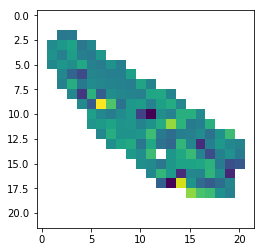

In [287]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(zi)

In [288]:
newmeangridnew = np.nanmean([zi],axis = 0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


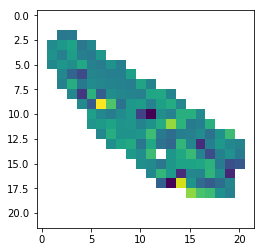

In [289]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(newmeangridnew)

In [290]:
griddednewlate = np.where(grid == True, newmeangridnew, grid)

In [291]:
d = np.where(np.isnan(griddednewlate), 0, griddednewlate)

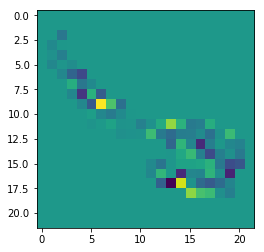

In [292]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(d)

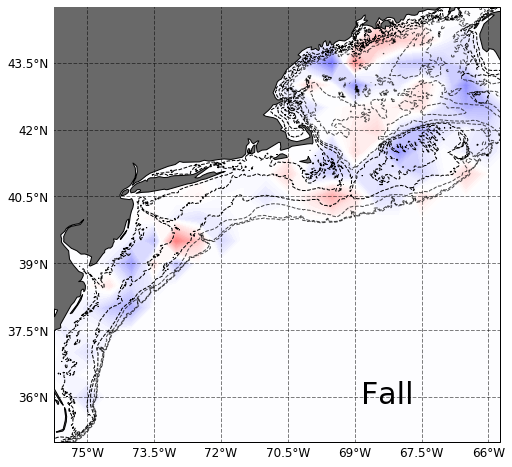

In [294]:
from matplotlib.pyplot import * ; import cartopy.feature as cfeature

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-75.75, -65.75, 35, 44.75], ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=0.5, linestyle='--', zorder = 20)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}

plt.text(-68.85, 35.85, 'Fall', dict(size=30))

cf = plt.contourf(xi,yi,d, np.arange(-110, 111,1), cmap = 'seismic')
ax.contour(lonNC, latNC, depthNC, [-300,-200,-100], linewidths=1,colors='black', alpha = 0.7,zorder=5) #alpha = 0.7
ax.contour(lonNC, latNC, depthNC, [-75,-50,-25], linewidths=1,colors='black',zorder=5)

feature = cfeature.NaturalEarthFeature(name='coastline', category='physical',scale='50m',edgecolor='black', facecolor='dimgray')
ax.add_feature(feature,zorder=10)
# cbar = plt.colorbar(cf, ax=ax)
# cbar.ax.get_yaxis().labelpad = 20
# cbar.ax.set_ylabel('MLD (m)', rotation=90, fontsize = 15)
# cbar.set_ticks([-110,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100,110])
# cbar.ax.tick_params(labelsize=12)

plt.savefig('seasonal_WGoM')

plt.show()

In [293]:
print(np.nanmax(d))
print(np.nanmean(d))
print(np.nanmin(d))

26.650567677261147
-0.6371125770145905
-30.313197498464387


In [ ]:
# Fall
26.650567677261147
-0.6371125770145905
-30.313197498464387
# Summer
3.6582920624318205
-0.60924205632057
-7.987603778095661
# Winter
max 86.20082585269257
mean -1.2975239753438004
min -72.2704656689445
# Spring
max 105.3171715844019
mean 0.45452345513755577
min -27.291586430087378